# Wind Turbines

This notebook implements some initial experiments in applying Cassandra to the wind turbines dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from sklearn.linear_model import LinearRegression

import os

from sqlalchemy import create_engine
from dotenv import load_dotenv

In [2]:
load_dotenv()
DATABASE_URL = os.getenv("DATABASE_URL")

engine = create_engine(DATABASE_URL)
conn = engine.connect()

In [3]:
df: pd.DataFrame = pd.read_sql("SELECT * FROM wind_turbines.observations_clean WHERE wind_turbine_name = 'R80711'", conn)
df['datetime'] = pd.to_datetime(df['datetime'], utc=True)

In [43]:
df_reduced = df[['datetime', 'ot', 'ws', 'rm', 'p']]
# only keep records with positive rm and p
df_reduced = df_reduced[(df_reduced['rm'] > 0) & (df_reduced['p'] > 0)]

## Data Exploration

We start with some diagnostic plots, to confirm whether a physically-informed model is appropriate.

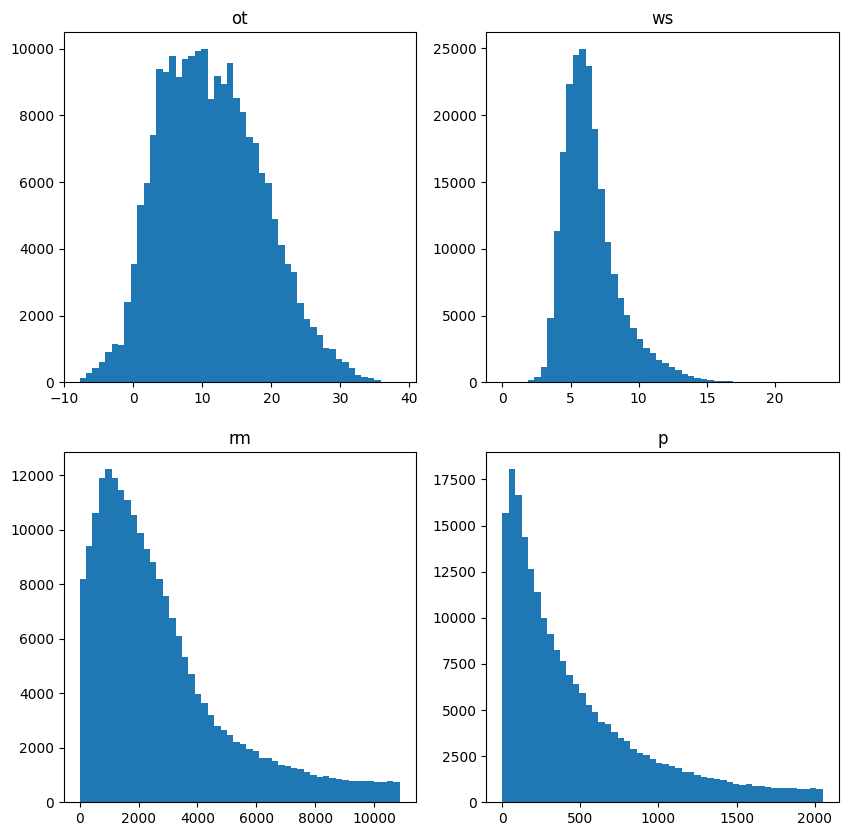

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for i, column in enumerate(df_reduced.columns[1:]):

    axes[i // 2, i % 2].hist(df_reduced[column], bins=50)
    axes[i // 2, i % 2].set_title(column)
plt.show()

Both the wind speed and temperature data are approximately normally distributed, with a slight skew towards higher values. Let's estimate the parameters of these distributions, and see how well they fit the data.

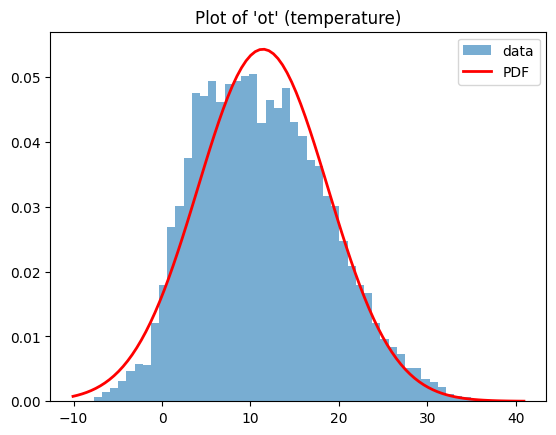

In [54]:

mean, std = np.mean(df_reduced['ot']), np.std(df_reduced['ot'])

plt.hist(df_reduced['ot'], bins=50, density=True, alpha=0.6, label='data')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)

plt.plot(x, p, 'r', linewidth=2, label='PDF')
plt.legend()
plt.title(f"Plot of 'ot' (temperature)")
plt.show()

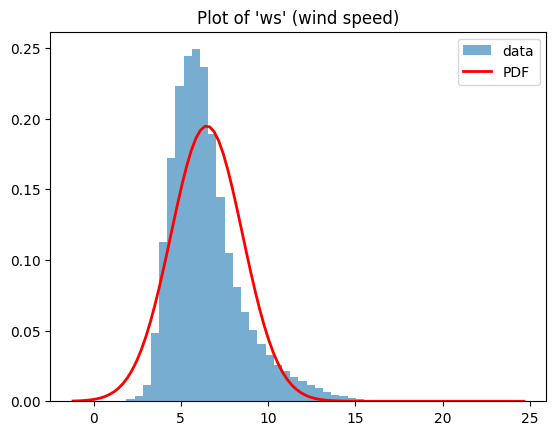

In [56]:
mean, std = np.mean(df_reduced['ws']), np.std(df_reduced['ws'])

plt.hist(df_reduced['ws'], bins=50, density=True, alpha=0.6, label='data')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)

plt.plot(x, p, 'r', linewidth=2, label='PDF')
plt.legend()
plt.title(f"Plot of 'ws' (wind speed)")
plt.show()

Not bad! Next, we know that the torque is proportional to the wind speed squared, so let's plot estimate the relationship between the two.

In [52]:
def torque_equation(wind_speed: float) -> float:
    return wind_speed ** 2

predicted_torque = df_reduced['ws'].apply(torque_equation)

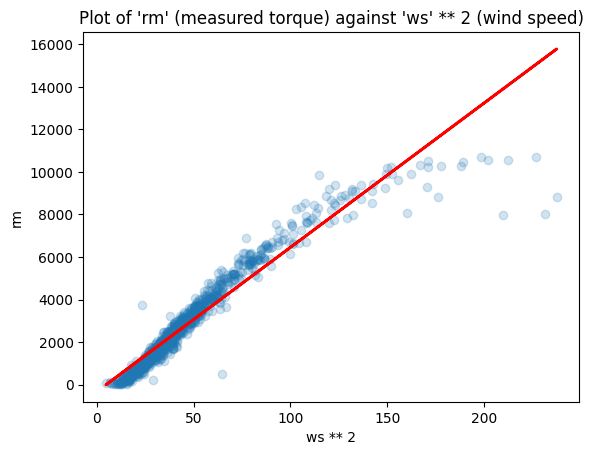

In [59]:

X = predicted_torque.values.reshape(-1, 1)
y = df_reduced['rm'].values.reshape(-1, 1)

reg = LinearRegression().fit(X, y)

random_indices = np.random.choice(len(X), size=1000, replace=False)
X_sample = X[random_indices]
y_sample = y[random_indices]

plt.scatter(X_sample, y_sample, alpha=0.2, label='data')
plt.plot(X_sample, reg.predict(X_sample), color='red', linewidth=2, label='prediction')
plt.xlabel("ws ** 2")
plt.ylabel("rm")
plt.title("Plot of 'rm' (measured torque) against 'ws' ** 2 (wind speed)")
plt.show()

Meanwhile, we know that torque and power are directly proportional, so let's plot that relationship too.

In [60]:
def power_equation(torque: float) -> float:
    return torque

predicted_power = df_reduced['rm'].apply(power_equation)

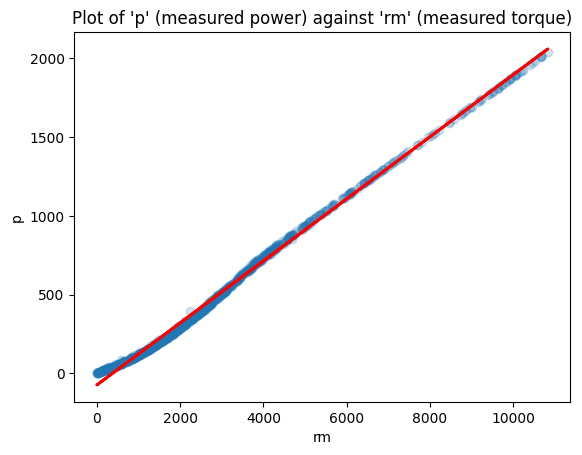

In [61]:

X = predicted_power.values.reshape(-1, 1)
y = df_reduced['p'].values.reshape(-1, 1)

reg = LinearRegression().fit(X, y)

random_indices = np.random.choice(len(X), size=1000, replace=False)
X_sample = X[random_indices]
y_sample = y[random_indices]

plt.scatter(X_sample, y_sample, alpha=0.2, label='data')
plt.plot(X_sample, reg.predict(X_sample), color='red', linewidth=2, label='prediction')
plt.xlabel("rm")
plt.ylabel("p")
plt.title("Plot of 'p' (measured power) against 'rm' (measured torque)")
plt.show()

Thus we have everything we need to construct a physically-informed Bayesian Network model of the wind turbine, using Cassandra.

## Modelling

We have all the parameters estimated from the data; let's use them to construct a Cassandra model.